<a href="https://colab.research.google.com/github/ferustigris/colab_invest/blob/master/portfolio_balance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# portfolio balance

# Framework

Data takes here https://finance.yahoo.com/quote/KO/history?p=KO

You can check online for RU stocks here https://ru.tradingview.com/chart/?symbol=MOEX%3AFXIT

In [4]:
!pip install yfinance

In [5]:
import pandas
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import numpy as np
import time
import math
from functools import reduce

from sklearn.metrics import r2_score, accuracy_score, f1_score, recall_score
from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform as sp_rand, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, power_transform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, VotingRegressor, BaggingRegressor

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import LinearLocator, AutoLocator, ScalarFormatter
# from mplfinance import candlestick2_ochl  #  pip install mpl-finance

from time import time, mktime
from datetime import datetime

from csv import QUOTE_NONNUMERIC

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download the data:

For cocal-cola (KO) downloaded from https://finance.yahoo.com/quote/KO/history?p=KO

In [7]:
import yfinance as yf

BLNS = 1000_000_000


class YahooFinanceReader:
    """Yahoo Finance Reader class for access via API"""

    class Ticker:
        """Case-class for the particular ticket"""

        def __init__(self, tkt):
            """Pass ticket object in the constructor"""
            self.tkt = tkt

        def get_current_price(self):
            """Get very current price of the ticket"""
            return self.tkt.info["currentPrice"]

        def get_divs(self):
            """Get annual divs of the ticket"""
            # print(self.tkt.dividends)
            print(self.tkt.info)
            return self.tkt.info["dividendYield"]

        def get_net(self):
            """Get annual netIncomeToCommon of the ticket in billions"""
            return self.tkt.info["netIncomeToCommon"] / BLNS

        def get_revenue(self):
            """Get annual totalRevenue of the ticket in billions"""
            return self.tkt.info["totalRevenue"] / BLNS

        def get_assets(self):
            """Get total assets of the ticket in billions"""
            return self.tkt.info["totalAssets"] / BLNS

        def get_shares(self):
            """Get shares volume of the ticket in billions"""
            return self.tkt.info["sharesOutstanding"] / BLNS

        def get_history(self):
          return self.tkt.history(period="max")

    def get_ticker(self, ticker_name):
        """Returns ticket object by ticket name"""
        print("Getting ticket object for %s..." % ticker_name)
        return self.Ticker(yf.Ticker(ticker_name))


In [8]:
def ts(date):
  return int(mktime(datetime.strptime(date, "%d/%m/%Y").timetuple()))

r = YahooFinanceReader()

def download(marker, start=ts("01/01/1971"), end=int(time())):
  # import requests
  # URL = "https://query1.finance.yahoo.com/v7/finance/download/%s?period1=%i&period2=%i&interval=1d&events=history&includeAdjustedClose=true" % (marker, start, end)
  # print(URL)
  # response = requests.get(URL)
  file_name = "%s.csv" % marker
  print(file_name)
  r.get_ticker(marker).get_history().to_csv(file_name)
  # open(file_name, "wb").write(response.content)

Moving average:

In [9]:
def default_formatting(draw, price_step=1, date_step=1):
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes()

    draw(ax)

    plt.xlabel("Date")
    plt.legend()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(round(start - start%price_step), end, price_step))
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, date_step))
    plt.grid(True)
    fig.autofmt_xdate()
    return plt

def avegare(df, name, long=20, short=5, price_step=1, date_step=1):
    def draw(ax):
        ax.plot(df['Date'], df['Close'], label=name, linewidth=2)
        ax.plot(df['Date'], df['Close'].rolling(short).mean(), label='Avg shortterm', linestyle='dashed', linewidth=1)
        ax.plot(df['Date'], df['Close'].rolling(long).mean(), label='Avg longterm', linestyle='dashed', linewidth=1)
    return default_formatting(draw, price_step, date_step)

def rolling(df, name, long=20, price_step=1, date_step=1):
    def draw(ax):
        ax.plot(df['Date'], df['Close'].rolling(long).mean(), label='Avg longterm', linestyle='dashed', linewidth=1)
    return default_formatting(draw, price_step, date_step)

In [10]:
def get_merged(tools):
    all_tools = []
    for tool in tools:
        print(tool)
        df = pandas.read_csv('%s.csv' % tool.upper(), sep=",", header=0)[['Close', 'Open']]
        df['Delta'] = df['Close'] - df['Open']
        df.rename(columns={'Delta':tool}, inplace=True)
        df.head()
        all_tools = all_tools + [df[[tool]]]
    df = reduce(lambda x,y: x.join(y), all_tools)
    return df

## Download data

In [11]:
tools=['HYMTF', 'BAS.DE', 'BMW.DE', 'NVS', 'DANOY', 'O',
       'MSFT', 'INTC',
       'BIDU', 'JD',
       'HOT.DE',
       'SNY', 'BAYN.DE',
       'ALV.DE', "RIO",
       'IAG.MC', 'REP.MC', 'RDS-A', 'OKE',
       'TSM', 'FRE.DE',
    # 'ORA',
    # 'TEF.MC',
    # 'GRF.MC',
    # 'TTE',
    # 'IBE.VI',
    # 'VWAGY',
    # 'BSN.F',
    # 'DTE.DE',
    # 'DPW.DE',
    # 'VNA.DE',
    # 'SIE.DE',
    # 'NSRGY',
    # 'SK3.IR',
    # 'RWE.DE'
       ]

In [12]:
for tool in tools:
  download(tool)

HYMTF.csv
Getting ticket object for HYMTF...
BAS.DE.csv
Getting ticket object for BAS.DE...
BMW.DE.csv
Getting ticket object for BMW.DE...
NVS.csv
Getting ticket object for NVS...
DANOY.csv
Getting ticket object for DANOY...
O.csv
Getting ticket object for O...
MSFT.csv
Getting ticket object for MSFT...
INTC.csv
Getting ticket object for INTC...
BIDU.csv
Getting ticket object for BIDU...
JD.csv
Getting ticket object for JD...
HOT.DE.csv
Getting ticket object for HOT.DE...
SNY.csv
Getting ticket object for SNY...
BAYN.DE.csv
Getting ticket object for BAYN.DE...
ALV.DE.csv
Getting ticket object for ALV.DE...
RIO.csv
Getting ticket object for RIO...
IAG.MC.csv
Getting ticket object for IAG.MC...
REP.MC.csv
Getting ticket object for REP.MC...
RDS-A.csv
Getting ticket object for RDS-A...


ERROR:yfinance:$RDS-A: possibly delisted; no timezone found


OKE.csv
Getting ticket object for OKE...
TSM.csv
Getting ticket object for TSM...
FRE.DE.csv
Getting ticket object for FRE.DE...


In [13]:
df_ibkr = get_merged(tools)

HYMTF
BAS.DE
BMW.DE
NVS
DANOY
O
MSFT
INTC
BIDU
JD
HOT.DE
SNY
BAYN.DE
ALV.DE
RIO
IAG.MC
REP.MC
RDS-A
OKE
TSM
FRE.DE


In [14]:
df_ibkr.head()

,HYMTF,BAS.DE,BMW.DE,NVS,DANOY,O,MSFT,INTC,BIDU,JD,...,SNY,BAYN.DE,ALV.DE,RIO,IAG.MC,REP.MC,RDS-A,OKE,TSM,FRE.DE
0,0.0,-0.008973,-0.017385,0.0,0.0,0.000000,0.005352,0.000000,5.654000,-0.794033,...,-0.329989,-0.293699,-0.387503,-0.023350,0.032573,-2.731137e-01,NaN,0.546367,0.340857,0.445940
1,0.0,-0.045802,-0.030313,0.0,0.0,0.095965,0.002141,-0.001452,-2.224999,-1.074279,...,-0.293826,0.144437,-0.667737,0.005838,-0.076002,-1.706963e-01,NaN,0.592539,-0.200504,-0.049334
2,0.0,0.067351,0.043687,0.0,0.0,-0.009597,0.001071,0.000000,-2.440001,2.512879,...,-0.180816,0.090576,-0.586993,0.005838,-0.019544,2.845002e-03,NaN,0.602158,-0.080201,0.049334
3,0.0,-0.017966,-0.050819,0.0,0.0,-0.019193,-0.001606,-0.000726,-0.925000,1.681482,...,0.113010,-0.004888,-0.505850,0.005838,-0.038002,-8.881784e-16,NaN,0.584844,-0.106935,0.344766
4,0.0,-0.125710,0.037445,0.0,0.0,-0.028790,-0.001070,-0.002904,0.670000,0.336295,...,0.027122,-0.220267,0.040375,-0.005838,-0.032572,1.194874e-01,NaN,0.573301,0.106936,0.000000


# Correlation

In [15]:
cr_ibkr = df_ibkr.corr(method='kendall')

<Axes: >

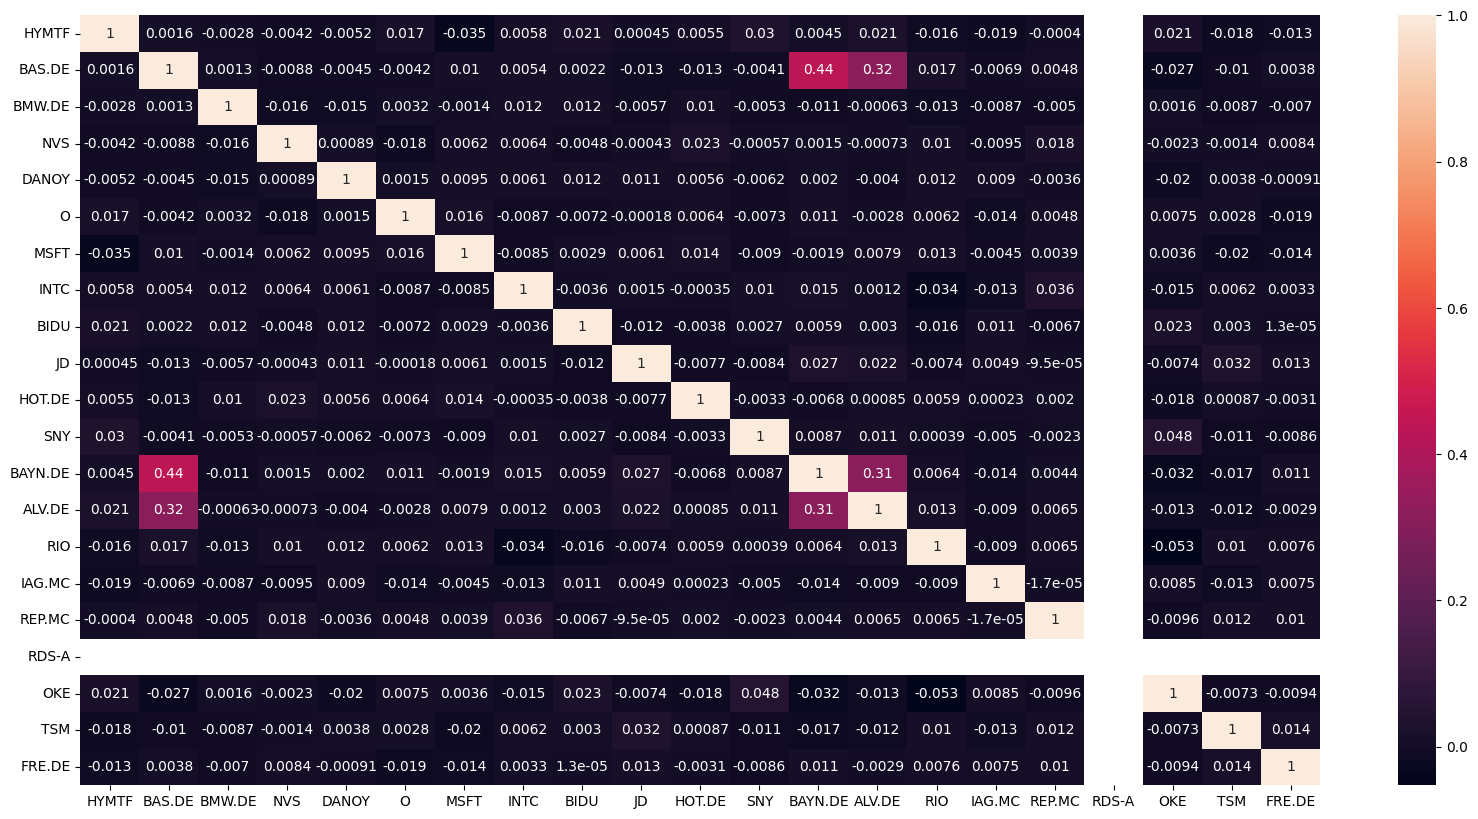

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(1, 1, 1)
sns.heatmap(cr_ibkr, xticklabels=cr_ibkr.columns, yticklabels=cr_ibkr.columns, annot=True)

O
HYMTF
MSFT
BAYN.DE
OKE
HOT.DE
RIO
REP.MC
BMW.DE
TSM
DANOY
JD
ALV.DE
BAS.DE
BIDU
SNY
INTC
IAG.MC
NVS
FRE.DE
RDS-A


<Axes: >

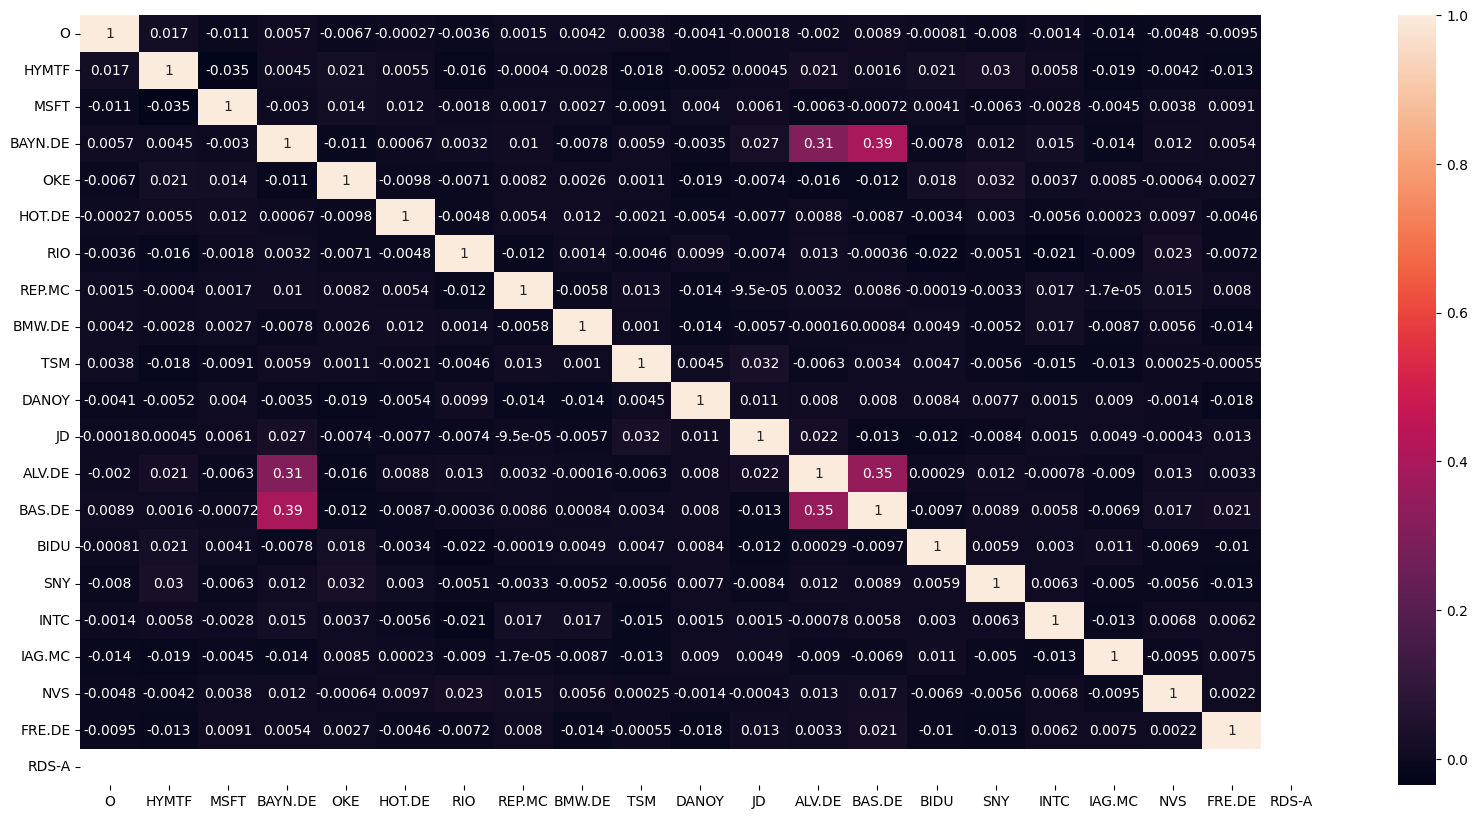

In [17]:
cr_ibkr_sort = cr_ibkr.sort_values('O', ascending=False).index.to_list()
df = get_merged(cr_ibkr_sort)
cr_ibkr2 = df.corr(method='kendall')

plt.figure(figsize=(20,10))
plt.subplot(1, 1, 1)
sns.heatmap(cr_ibkr2, xticklabels=cr_ibkr2.columns, yticklabels=cr_ibkr2.columns, annot=True)